In [1]:
import torch
import matplotlib.pyplot as plt
from graphxai.datasets import ShapeGraph

In [2]:
dataset = ShapeGraph(
    model_layers = 3,
    num_subgraphs = 100,
    subgraph_size = 12,
    prob_connection = 0.1,
    add_sensitive_feature = False
)

100%|██████████| 943/943 [00:03<00:00, 271.45it/s]


In [3]:
from torch_geometric.nn import GINConv

class GNN(torch.nn.Module):
    def __init__(self,input_feat, hidden_channels, classes = 2):
        super(GNN, self).__init__()
        self.mlp_gin1 = torch.nn.Linear(input_feat, hidden_channels)
        self.gin1 = GINConv(self.mlp_gin1)
        self.mlp_gin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.gin2 = GINConv(self.mlp_gin2)
        self.mlp_gin3 = torch.nn.Linear(hidden_channels, classes)
        self.gin3 = GINConv(self.mlp_gin3)

    def forward(self, x, edge_index):
        # NOTE: our provided testing function assumes no softmax
        #   output from the forward call.
        x = self.gin1(x, edge_index)
        x = x.relu()
        x = self.gin2(x, edge_index)
        x = x.relu()
        x = self.gin3(x, edge_index)
        return x

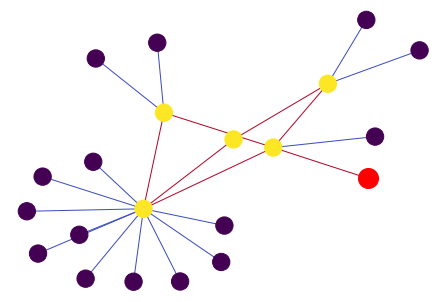

In [4]:
# Show a node:
data = dataset.get_graph(use_fixed_split=True)

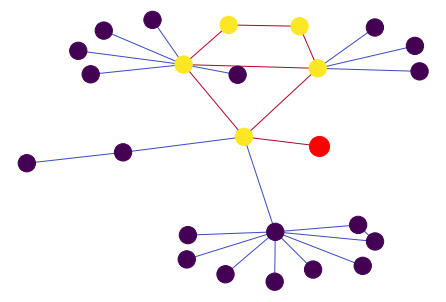

In [26]:
node_idx = data.test_mask.nonzero(as_tuple=True)[0][13]

gt_exp = dataset.explanations[node_idx]
gt_exp[0].visualize_node(num_hops = 3, additional_hops = 0, graph_data = data, show = True)

In [5]:
# Class imbalance:

print(torch.sum(data.y == 0))
print(torch.sum(data.y == 1))

tensor(301)
tensor(853)


In [6]:
# Train GNN:

from graphxai.gnn_models.node_classification import train, test

model = GNN(dataset.n_features, 64)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)
criterion = torch.nn.CrossEntropyLoss()

# Train model:
for _ in range(1500):
    loss = train(model, optimizer, criterion, data)

# Final testing performance:
f1, acc, prec, rec, auprc, auroc = test(model, data, num_classes = 2, get_auc = True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))

Test F1 score: 0.9308
Test AUROC: 0.8802


In [7]:
# Do we get chosen correct?
pred = model(data.x, data.edge_index)[node_idx,:].argmax(dim=0)
label = data.y[node_idx]

print(f'Prediction = {pred.item()}')
print(f'Label = {label.item()}')

# YES

Prediction = 0
Label = 0


In [8]:
# Get explainers:
from graphxai.explainers import *

device = None

def get_exp_method(method, model, criterion, node_idx, pred_class):
    method = method.lower()
    if method=='gnnex':
        exp_method = GNNExplainer(model)
        forward_kwargs={'x': data.x.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='grad':
        exp_method = GradExplainer(model, criterion = criterion)
        forward_kwargs={'x': data.x.to(device),
                        'y': data.y.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='cam':
        exp_method = CAM(model, activation = lambda x: torch.argmax(x, dim=1))
        forward_kwargs={'x': data.x.to(device),
                        'y': data.y.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='gcam':
        exp_method = GradCAM(model, criterion = criterion)
        forward_kwargs={'x':data.x.to(device),
                        'y': data.y.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device),
                        'average_variant': [True]}
    elif method=='gbp':
        exp_method = GuidedBP(model, criterion = criterion)
        forward_kwargs={'x': data.x.to(device),
                        'y': data.y.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='glime':
        exp_method = GraphLIME(model)
        forward_kwargs={'x': data.x.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='ig':
        exp_method = IntegratedGradExplainer(model, criterion = criterion)
        forward_kwargs = {'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'node_idx': int(node_idx),
                        'label': pred_class}
    elif method=='glrp':
        exp_method = GNN_LRP(model)
        forward_kwargs={'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'node_idx': node_idx,
                        'label': pred_class,
                        'edge_aggregator':torch.sum}
    elif method=='pgmex':
        exp_method=PGMExplainer(model, explain_graph=False, p_threshold=0.1)
        forward_kwargs={'node_idx': node_idx,
                        'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'top_k_nodes': 10}
    elif method=='pgex':
        exp_method=PGEX
        forward_kwargs={'node_idx': node_idx,
                        'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'label': pred_class}
    elif method=='rand':
        exp_method = RandomExplainer(model)
        forward_kwargs={'x': data.x.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='subx':
        exp_method = SubgraphX(model, reward_method = 'gnn_score', num_hops = dataset.model_layers, rollout=5)
        forward_kwargs={'node_idx': node_idx,
                        'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'label': pred_class,
                        'max_nodes': 10}
    else:
        OSError('Invalid argument!!')
    return exp_method, forward_kwargs

In [ ]:
# Train PGExplainer:
PGEX = PGExplainer(model, emb_layer_name = 'gin3', max_epochs = 10, lr = 0.1)
PGEX.train_explanation_model(data)

E = gnnex
E = gcam
E = subx
args 56 3 tensor([[   0,    0,    0,  ..., 1153, 1153, 1153],
        [   1,    2,    3,  ...,    1,  665, 1148]])
E = pgex
E = rand
E = pgmex


  0%|          | 0/1000000 [00:00<?, ?it/s]

E = gbp
E = cam
E = grad


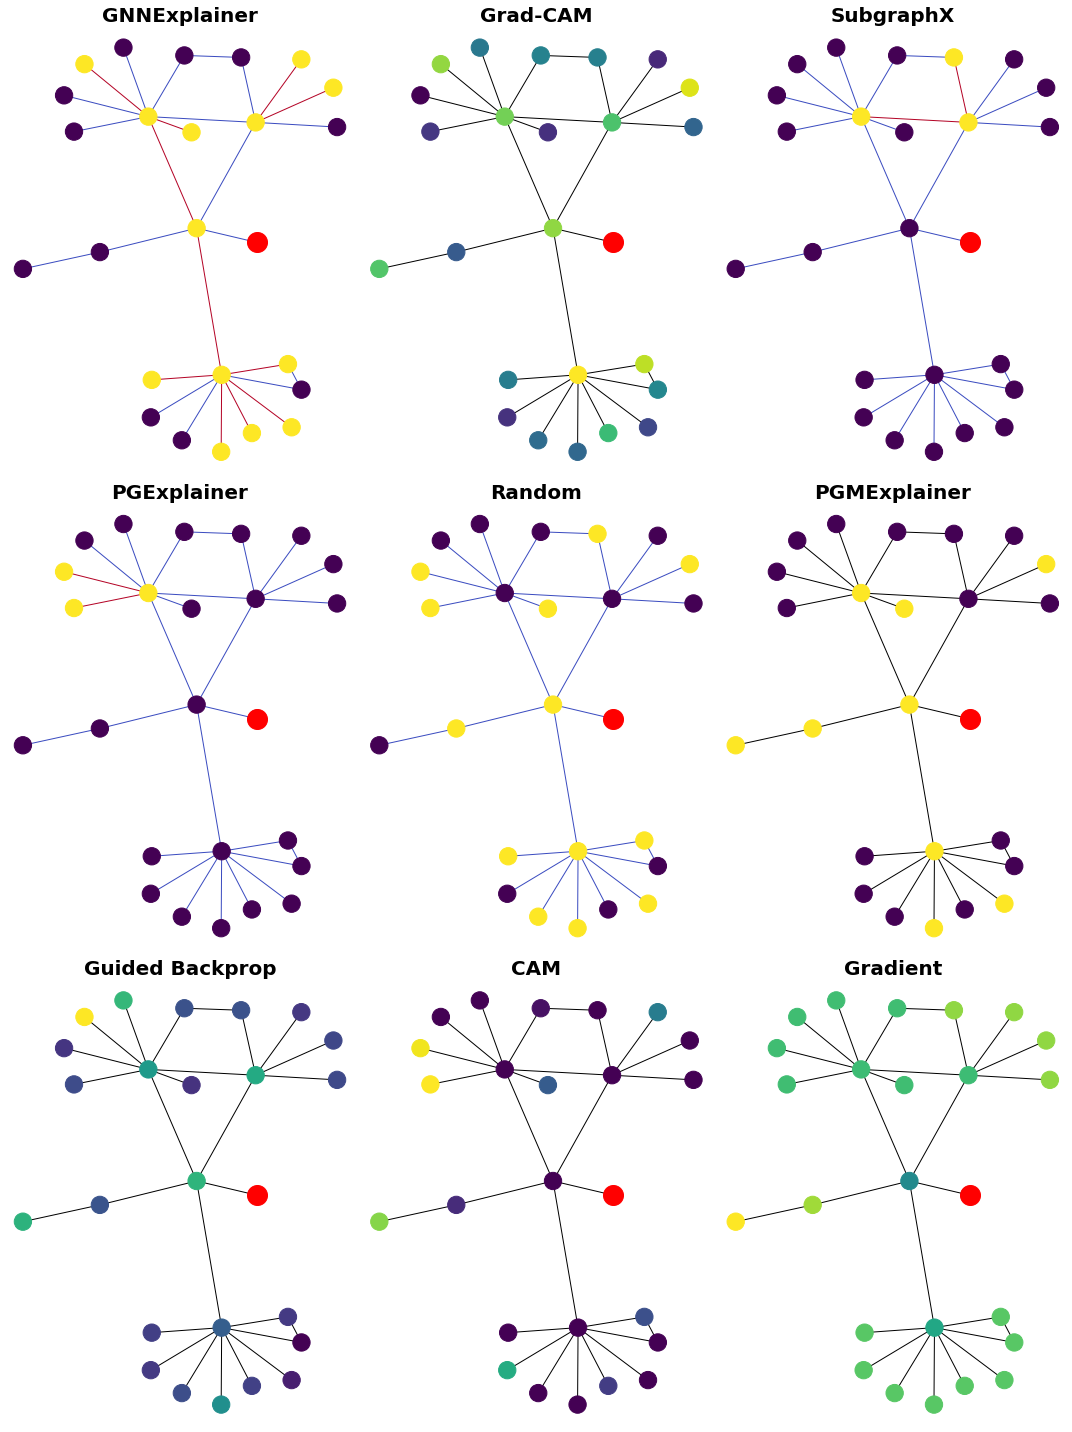

In [33]:
exp_list = ['gnnex', 'gcam', 'subx', 'pgex', 
            'rand',  'pgmex', 'gbp', 'cam', 'grad']

exp_name_map = {
    'gnnex': 'GNNExplainer',
    'gcam': 'Grad-CAM',
    'subx': 'SubgraphX',
    'rand': 'Random',
    'pgmex': 'PGMExplainer',
    'pgex': 'PGExplainer',
    'gbp': 'Guided Backprop',
    'cam': 'CAM',
    'grad': 'Gradient' 
}

# Number: 10

fig, ax = plt.subplots(3, 3, tight_layout = True, figsize=(15, 20))

# inds = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
#         (1, 0), (1, 1), (1, 2), (1, 3), (1, 4)]

#inds = [(p[1], p[0]) for p in inds]

inds = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

# gt_exp[0].visualize_node(num_hops = 3, additional_hops = 0, graph_data = data, ax = ax[inds[0][0], inds[0][1]])
# ax[0,0].set_title('Ground Truth', fontsize = 20, fontweight = 'semibold')

for i in range(0, 9):
    E = exp_list[i]
    print(f'E = {E}')
    EXP, fwargs = get_exp_method(
        method = E,
        model = model,
        criterion = criterion,
        node_idx = node_idx.item(),
        pred_class = pred.clone()
        )

    exp = EXP.get_explanation_node(**fwargs)
    
    exp.visualize_node(num_hops = 3, additional_hops = 0, graph_data = data, 
                       ax = ax[inds[i][0], inds[i][1]], norm_imps = False)
    
    ax[inds[i][0], inds[i][1]].set_title(exp_name_map[E], fontsize = 20, fontweight = 'semibold')

plt.savefig('vis_img.pdf', format = 'pdf', dpi = 150)

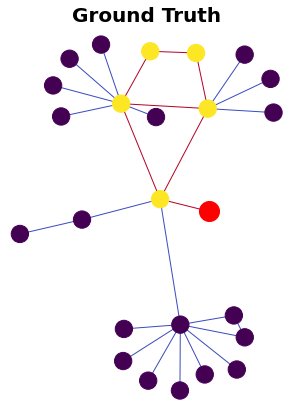

In [46]:
plt.figure(figsize=(5, 7))
plt.title('Ground Truth', fontsize = 20, fontweight = 'semibold')
gt_exp[0].visualize_node(num_hops = 3, additional_hops = 0, graph_data = data, show = False)
plt.savefig('gt.pdf', format = 'pdf')